In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [65]:
data = pd.read_csv("admData.csv")
data.head()

,InquiryDate,DailyAdmission
0,8/22/2017,41
1,8/23/2017,47
2,8/24/2017,56
3,8/25/2017,63
4,8/26/2017,70


In [66]:
from datetime import datetime
con= data['InquiryDate']
data['InquiryDate'] = pd.to_datetime(data['InquiryDate'])
data.set_index('InquiryDate', inplace = True)

In [73]:
data = data['2017-08-22': '2018-08-16']

In [74]:
np.random.seed(9001)
train_portion = round(data.shape[0]*.6)
val_portion = round(data.shape[0]*.2)

train_data = data[0:train_portion]
val_data = data[train_portion: val_portion+train_portion]

test_data =data[train_portion+val_portion:]

In [75]:
tr_data = train_data['DailyAdmission']
ts_data = test_data['DailyAdmission']

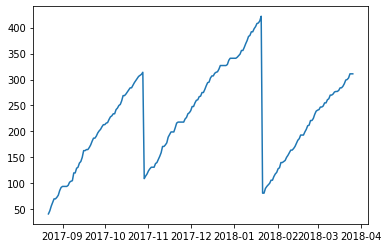

In [71]:
plt.plot(tr_data)

In [89]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries): 
    #determining rolling statistics
    rolmean = pd.rolling_mean(timeseries, window = 7)
    rolstd = pd.rolling_std(timeseries, window = 7)
    
    
#plot rolling statistics: 
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label ='Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean & Standard Deviation')
    plt.show()
    
    #perform dickey-fuller test:
    print('results of dickey-fuller test: ')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s): ' %key]  = value
    print(dfoutput)
    

C:\Users\saxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\saxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  """


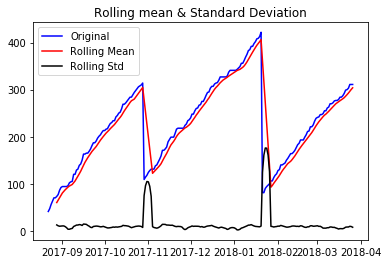

results of dickey-fuller test: 
Test Statistics                 -2.684784
p-value                          0.076709
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%):            -3.461282
Critical Value (5%):            -2.875143
Critical Value (10%):           -2.574020
dtype: float64


In [90]:
test_stationarity(tr_data)

C:\Users\saxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """Entry point for launching an IPython kernel.


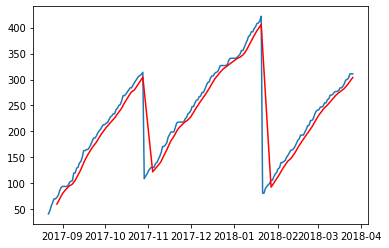

In [78]:
moving_avg = pd.rolling_mean(tr_data,7)
plt.plot(tr_data)
plt.plot(moving_avg, color = 'red')

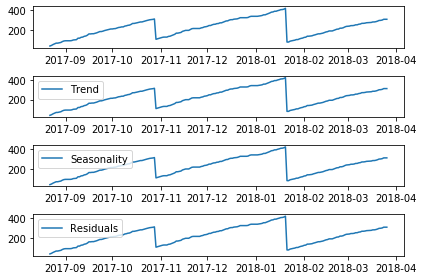

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tr_data, freq=13)

decomp = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tr_data, label = 'Original')
#plt.legend(log = 'best')
plt.subplot(412)
plt.plot(tr_data, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(tr_data, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(tr_data, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

Text(0.5, 1.0, 'Partial Autocorrelation Function')

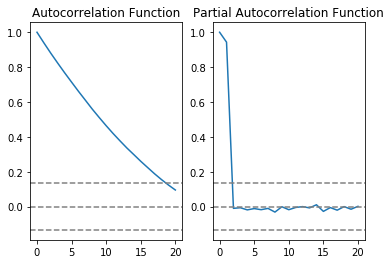

In [101]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(tr_data, nlags = 20)
lag_pacf = pacf(tr_data, nlags = 20, method = 'ols')

#Plot ACF

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'grey')
plt.axhline(y=1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')
# plt.title_layout()

AR model

C:\Users\saxen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\saxen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 269.7004')

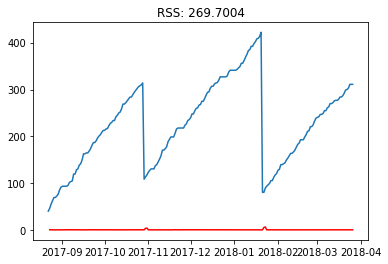

In [110]:
model = ARIMA(tr_data, order = (2,1,0))
results_AR = model.fit(disp = 7)
plt.plot(tr_data)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues)))

MA Model

C:\Users\saxen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\saxen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 269.6962')

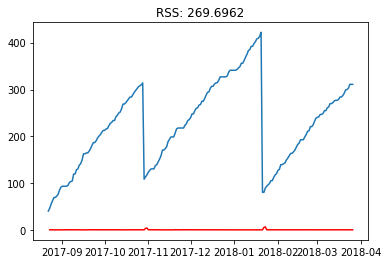

In [111]:
model = ARIMA(tr_data, order = (0,1,2))
results_MA = model.fit(disp = 7)
plt.plot(tr_data)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f' % sum((results_MA.fittedvalues)))

ARIMA Model

In [115]:
model = ARIMA(tr_data, order = (2,1,2))
# results_ARIMA = model.fit(disp = 1)
# plt.plot(tr_data)
# plt.plot(results_ARIMA.fittedvalues, color = 'red')
# plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues)**2))

C:\Users\saxen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\saxen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The MA model has a better RSS but still not good

In [ ]:
#RMSE

#predictions_MA = np.exp(predictions_MA_log)
